In [1]:
import os
import numpy as np
from MaskRCNN import model as modellib
from MaskRCNN import coco, visualize
from MaskRCNN.model import log
import cv2
import time
from collections import deque
from scipy.stats import norm
import dlib
import imutils
%run DeepBall.ipynb

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs
1 Physical GPUs, 1 Logical GPUs
2.0.0
True
True
156.07745
0.7647059


In [34]:
boxes = np.arange(40).reshape((10,4))
y,x = 36,39
print(boxes)
intersect = np.logical_and(np.logical_and(boxes[:,0] <= y, y <= boxes[:,2]), 
                           np.logical_and(boxes[:,1] <= x, x <= boxes[:,3]))
print(np.any(intersect))
feet_points = np.stack((boxes[:,0], (boxes[:,1] + boxes[:,3]) // 2, boxes[:,2] - boxes[:,0]), axis=-1)
print(feet_points)
# keypoints = np.arange(40).reshape((5,4,2))
# keypoints.reshape((-1,2))[:,:-1]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]]
True
[[ 0  2  2]
 [ 4  6  2]
 [ 8 10  2]
 [12 14  2]
 [16 18  2]
 [20 22  2]
 [24 26  2]
 [28 30  2]
 [32 34  2]
 [36 38  2]]


In [49]:
ROOT_DIR = os.getcwd()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "mylogs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "MaskRCNN", "mask_rcnn_coco_humanpose.h5")
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    KEYPOINT_MASK_POOL_SIZE = 7

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)
# Get path to saved weights

model_path = COCO_MODEL_PATH
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
# DeepBall Model Loading
deepball_model = deepball()
deepball_model.load_weights('deepballmini2.h5')

class_names = ['BG', 'person']
def cv2_display_keypoint(image,boxes,keypoints,masks,class_ids,scores,class_names,skeleton = inference_config.LIMBS):
    # Number of persons
    N = boxes.shape[0]
    if not N:
        print("\n*** No persons to display *** \n")
    else:
        assert N == keypoints.shape[0] and N == class_ids.shape[0] and N==scores.shape[0],\
            "shape must match: boxes,keypoints,class_ids, scores"
    colors = visualize.random_colors(N)
    for i in range(N):
        color = colors[i]
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness=2)
        for Joint in keypoints[i]:
            if (Joint[2] != 0):
                cv2.circle(image,(Joint[0], Joint[1]), 2, color, -1)

        #draw skeleton connection
#         limb_colors = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
#                        [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255], [170, 170, 0], [170, 0, 170]]
#         if (len(skeleton)):
#             skeleton = np.reshape(skeleton, (-1, 2))
#             neck = np.array((keypoints[i, 5, :] + keypoints[i, 6, :]) / 2).astype(int)
#             if (keypoints[i, 5, 2] == 0 or keypoints[i, 6, 2] == 0):
#                 neck = [0, 0, 0]
#             limb_index = -1
#             for limb in skeleton:
#                 limb_index += 1
#                 start_index, end_index = limb  # connection joint index from 0 to 16
#                 if (start_index == -1):
#                     Joint_start = neck
#                 else:
#                     Joint_start = keypoints[i][start_index]
#                 if (end_index == -1):
#                     Joint_end = neck
#                 else:
#                     Joint_end = keypoints[i][end_index]
#                 # both are Annotated
#                 # Joint:(x,y,v)
#                 if ((Joint_start[2] != 0) & (Joint_end[2] != 0)):
#                     # print(color)
#                     cv2.line(image, tuple(Joint_start[:2]), tuple(Joint_end[:2]), limb_colors[limb_index],3)
        mask = masks[:, :, i]
        image = visualize.apply_mask(image, mask, color)
        caption = "{} {:.3f}".format(class_names[class_ids[i]], scores[i])
        cv2.putText(image, caption, (x1 + 5, y1 + 16), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color)
    return image

def display_ball_box(image, x, y, keypoints, boxes, history):
    if x < 0:
        print("\n*** No ball detected ***\n")
    else:
        intersect = np.logical_and(np.logical_and(boxes[:,0] <= y, y <= boxes[:,2]), 
                           np.logical_and(boxes[:,1] <= x, x <= boxes[:,3]))
        feet_points = np.stack((boxes[:,0], (boxes[:,1] + boxes[:,3]) // 2, (boxes[:,2] - boxes[:,0])//2), axis=-1)
        ball_pos = np.array([y,x])
#         player_points = keypoints[:,:,:-1].reshape((-1,2))
        distances = np.linalg.norm(ball_pos - feet_points[:,:-1], axis=1)
        closeOrNot = np.less_equal(distances, feet_points[:,-1])
        
        near_player = np.any(closeOrNot) or np.any(intersect)
        still = False
        if len(history) > 4:
            print(history, (y,x))
            still = ((y,x) == history[-1] and (y,x) == history[-2] and (y,x) == history[-3] and 
                     (y,x) == history[-4] and (y,x) == history[-5])
        if still and not near_player:
            status = "OutOfBounds"
        elif near_player:
            status = "Possession"
            history.clear()
        else:
            status = "Pass"
            
        caption = "Action : {}".format(status)
        cv2.circle(image, (x, y), 16, (255,0,0), thickness=2)
        cv2.putText(image, caption, (100,100), cv2.FONT_HERSHEY_PLAIN, 2.8, (255,255,255), thickness=2)
        
    return image

Loading weights from  E:\CSE707\DeepBall\MaskRCNN\mask_rcnn_coco_humanpose.h5


In [50]:
def passTrack(cap, output):
    trackers = []
    i = 0
    frame_rate_divider = 1
    bpos = deque()
    while(cap.isOpened()):
        stime = time.time()
        ret, frame = cap.read()
        if ret:
            if i % frame_rate_divider == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                (h, w) = frame.shape[:2]

                results = model.detect_keypoint([frame], verbose=0)
                cmap = deepball_model.predict(np.array([cv2.resize(frame, (480,272))]), batch_size=1, verbose=1)
                cm = cmap[0,:,:,0]
                pos = np.unravel_index(np.argmax(cm, axis=None), cm.shape)
                y,x = pos
                x = -1 if cm[y,x] < 0.3 else x
                y,x = y * 16, x * 16

                r = results[0]

                result_frame = cv2_display_keypoint(frame,r['rois'],r['keypoints'],r['masks'],r['class_ids'],r['scores'],class_names)
                ball_frame = display_ball_box(result_frame, x, y, r['keypoints'], r['rois'], bpos)
                bpos.append((y,x))
                output.write(ball_frame)
                cv2.imshow('frame', ball_frame)
                i += 1
                
            print('FPS {:.1f}'.format(1 / (time.time() - stime)))

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    output.release()
    cv2.destroyAllWindows()

In [51]:
def fieldSegment(cap):
    i = 0
    frame_rate_divider = 1
    greenPeaks = []
    greenStds = []
    gMean = 94.9775
    while(cap.isOpened()):
        stime = time.time()
        ret, frame = cap.read()
        if ret:
            if i == 1000:
                grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                dst = cv2.Canny(grayFrame, 50, 200, None, 3)
    
                # Copy edges to the images that will display the results in BGR
                cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
                cdstP = np.copy(cdst)

                lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

                if lines is not None:
                    for i in range(0, len(lines)):
                        rho = lines[i][0][0]
                        theta = lines[i][0][1]
                        a = math.cos(theta)
                        b = math.sin(theta)
                        x0 = a * rho
                        y0 = b * rho
                        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
                        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
                        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
            
    
                gFrame = cv2.split(frame)[1]

                mu, sigma = norm.fit(gFrame.ravel())
                print(gMean, sigma)
                cv2.imwrite("frame.png", frame)
                _,segFrame = cv2.threshold(gFrame, gMean + sigma, 255, cv2.THRESH_TOZERO_INV)
#                 print(type(segFrame), segFrame)
                _,segFrame = cv2.threshold(segFrame, gMean - sigma, 255, cv2.THRESH_TOZERO)
                plt.figure()
                plt.subplot(211)
                plt.imshow(segFrame, cmap='gray')
                plt.subplot(212)
                plt.imshow(cdst)
                cv2.imwrite("segFrame.png", segFrame)
                
                return segFrame/255.0
                break
            
            else:

#                 gFrame = cv2.split(frame)[1]

#                 peak = np.amax(gFrame)
#                 greenPeaks.append(peak)
    #             print('frame {} processed'.format(i))
                i+=1
        else:
            break
        

In [52]:
cap = cv2.VideoCapture('Seq6Sub.avi')
size = (
	int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
	int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
codec = cv2.VideoWriter_fourcc(*'DIVX')
output = cv2.VideoWriter('Seq6STest.avi',codec,25.0,size)
# outputSeg = cv2.VideoWriter('Seq6Seg.avi', codec,25.0,size)

94.9775 22.576295005646287


<IPython.core.display.Javascript object>


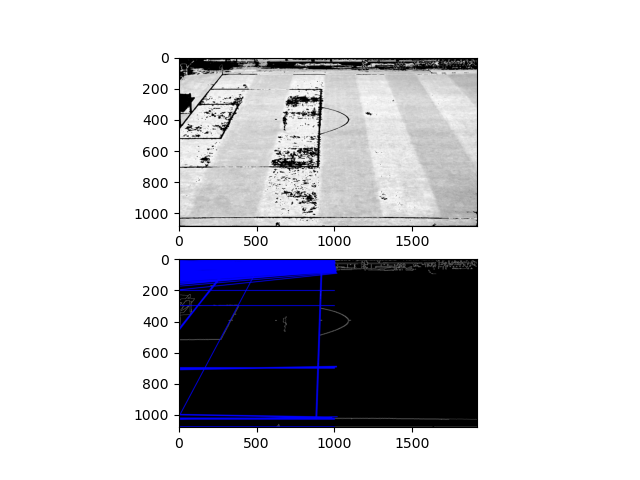

In [26]:
mask = fieldSegment(cap)

In [53]:
passTrack(cap, output)

1/1 [==============================] - 0s 146ms/step
FPS 0.2
1/1 [==============================] - 0s 4ms/step
FPS 0.8
1/1 [==============================] - 0s 3ms/step
FPS 0.8
1/1 [==============================] - 0s 4ms/step
FPS 0.8
1/1 [==============================] - 0s 4ms/step
FPS 0.8
1/1 [==============================] - 0s 3ms/step
deque([(64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456)]) (64, 1456)
FPS 0.8
1/1 [==============================] - 0s 3ms/step
deque([(64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456)]) (64, 1456)
FPS 0.8
1/1 [==============================] - 0s 4ms/step
deque([(64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456)]) (64, 1456)
FPS 0.7
1/1 [==============================] - 0s 3ms/step
deque([(64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456), (64, 1456)]) (64, 1456)
FPS 0.8
1/1 [==============================] - 0s 4ms/step
deque([(64, 1456), (64, 1456

deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752)]) (576, 736)
FPS 0.6
1/1 [==============================] - 0s 3ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736)]) (576, 704)
FPS 0.6
1/1 [==============================] - 0s 3ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736), (576, 704)]) (592, 688)
FPS 0.6
1/1 [==============================] - 0s 4ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736), (576, 704), (592, 688)]) (592, 656)
FPS 0.6
1/1 [==============================] - 0s 3ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736), (576, 704), (592, 688), (592, 656)]) (592, 640)
FPS 0.5
1/1 [==============================] - 0s 4ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (57

1/1 [==============================] - 0s 4ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736), (576, 704), (592, 688), (592, 656), (592, 640), (608, 624), (608, 592), (624, 576), (640, 560), (640, 528), (656, 512), (672, 496), (688, 464), (704, 448), (720, 432), (736, 400), (720, 400), (720, 384), (704, 368), (704, 352), (688, 336), (688, 320), (688, 304), (688, 304), (672, 288), (672, 272), (672, 256)]) (672, 240)
FPS 0.6
1/1 [==============================] - 0s 4ms/step
deque([(688, 976), (576, 864), (576, 848), (576, 816), (576, 800), (576, 768), (576, 752), (576, 736), (576, 704), (592, 688), (592, 656), (592, 640), (608, 624), (608, 592), (624, 576), (640, 560), (640, 528), (656, 512), (672, 496), (688, 464), (704, 448), (720, 432), (736, 400), (720, 400), (720, 384), (704, 368), (704, 352), (688, 336), (688, 320), (688, 304), (688, 304), (672, 288), (672, 272), (672, 256), (672, 240)]) (672, 224)
FPS 0.6
1/1 [===========

1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 3ms/step
FPS 0.5
1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 3ms/step
FPS 0.5
1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 3ms/step
FPS 0.5
1/1 [==============================] - 0s 4ms/step
FPS 0.6
1/1 [==============================] - 0s 4ms/step
FPS 0.6
1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 3ms/step
FPS 0.5
1/1 [==============================] - 0s 3ms/step
FPS 0.6
1/1 [==============================] - 0s 3ms/step
FPS 0.6
1/1 [==============================] - 0s 4ms/step
FPS 0.5
1/1 [==============================] - 0s 4ms/step
deque([(528, 160), (528, 160), (544, 176), (544, 176), (544, 176)]) (560, 176)
FPS 0.5
1/1 [==============================]

1/1 [==============================] - 0s 4ms/step
deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), (592, 304), (592, 320), (592, 320), (592, 320), (592, 336), (592, 336), (592, 336), (592, 336)]) (592, 352)
FPS 0.4
1/1 [==============================] - 0s 4ms/step
deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), (592, 304), (592, 320), (592, 320), (592, 320), (592, 336), (592, 336), (592, 336), (592, 336), (592, 352)]) (592, 352)
FPS 0.4
1/1 [==============================] - 0s 4ms/step
deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), (592, 304), (592, 320), (592, 320), (592, 320), (592, 336), (592, 336), (592, 336), (592, 336), (592, 352), (592, 352)]) (592, 352)
FPS 0.4
1/1 [==============================] - 0s 4ms/step
deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), 

deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), (592, 304), (592, 320), (592, 320), (592, 320), (592, 336), (592, 336), (592, 336), (592, 336), (592, 352), (592, 352), (592, 352), (592, 368), (592, 368), (592, 368), (592, 384), (592, 384), (592, 384), (592, 400), (592, 400), (592, 400), (592, 400), (592, 416), (592, 416), (592, 416), (592, 432), (592, 432), (592, 432), (592, 448), (592, 448)]) (592, 448)
FPS 0.5
1/1 [==============================] - 0s 4ms/step
deque([(576, 224), (576, 240), (576, 256), (576, 256), (576, 272), (592, 288), (592, 288), (608, 304), (592, 304), (592, 320), (592, 320), (592, 320), (592, 336), (592, 336), (592, 336), (592, 336), (592, 352), (592, 352), (592, 352), (592, 368), (592, 368), (592, 368), (592, 384), (592, 384), (592, 384), (592, 400), (592, 400), (592, 400), (592, 400), (592, 416), (592, 416), (592, 416), (592, 432), (592, 432), (592, 432), (592, 448), (592, 448), (592, 448)]) (592, 448)
FPS

In [ ]:

#                 if len(trackers) == 0:
#                     # grab the frame dimensions and convert the frame to a blob
#                     (h, w) = frame.shape[:2]
                    
#                     results = model.detect_keypoint([frame], verbose=0)
                    
#                     r = results[0]
                    
                    
#                     for i in range(r['rois'].shape[0]):
#                         box = r['rois'][i]
#                         (startX, startY, endX, endY) = box.astype("int")
                        
#                         t = dlib.correlation_tracker()
#                         rect = dlib.rectangle(startX, startY, endX, endY)
#                         t.start_track(rgb, rect)
                        
#                         trackers.append(t)
                        
#                         cv2.rectangle(frame, (startX, startY), (endX, endY), (0,0,255), 2)
                    
#                     frame = display_ball_box(frame, x, y, r['keypoints'], r['rois'])
                    
#                     i += 1
                
#                 else:
#                     boxes = np.ones((len(trackers), 4))
#                     for i,t in enumerate(trackers):
#                         t.update(rgb)
#                         pos = t.get_position()
                        
#                         # unpack the position object
#                         startX = int(pos.left())
#                         startY = int(pos.top())
#                         endX = int(pos.right())
#                         endY = int(pos.bottom())
                        
#                         boxes[i] = np.array([startY, startX, endY, endX])